In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from time import time
import mplcyberpunk as cp
%matplotlib inline
plt.style.use('../dark-custom.mplstyle')

In [2]:
import sys
sys.path.append('..')
from ModelClasses.Autoencoders import (
    DenseVariationalAutoencoder,
    ConvolutionalVariationalAutoencoder
)
from Utils import (
    plot_loss,
    compare_generated_to_original_mnist,
    get_dict_of_latent_spaces,
    compare_latent_spaces,
    zoom_limits,
    dataset_subset
)

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training Dense VAE

In [4]:
DATA_PATH = '../Datasets/data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])
mnist_train = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)

In [5]:
class KLDivergence(nn.Module):

    def __init__(self, kld_weight=0.02):
        super(KLDivergence, self).__init__()
        self.kld_weight = kld_weight

    def forward(self, mu, logvar):
        kl_batch = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        kl_loss = torch.mean(kl_batch, dim=0)
        return self.kld_weight * kl_loss


class VAELoss(nn.Module):
    
    def __init__(self, reconstruction_loss=nn.MSELoss(), kld_weight=0.02):
        super(VAELoss, self).__init__()
        self.reconstruction_loss = reconstruction_loss
        self.kl_divergence = KLDivergence(kld_weight=kld_weight)

    def forward(self, r_x, x, mu, logvar):
        reconstruction_loss = self.reconstruction_loss(r_x, x)
        kl_loss = self.kl_divergence(mu, logvar)
        total_loss = reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss.detach(), kl_loss.detach()


In [6]:
def vae_train_loop(model, dataloader, criterion, 
                   optimizer, device, epochs):
    recon_loss_list = []
    kl_loss_list = []
    total_loss_list = []
    model.train()
    with tqdm(range(epochs)) as pbar:
        for _ in pbar:
            recon_loss_train = 0
            kl_loss_train = 0
            total_loss_train = 0
            for x_true, _ in dataloader:
                x_true = x_true.to(device)
                x_pred, mu, logvar = model(x_true)
                total_loss, recon_loss, kl_loss = criterion(x_pred, x_true, mu, logvar)
                optimizer.zero_grad()
                total_loss.backward()
                recon_loss_train += (recon_loss_value := recon_loss.item())
                kl_loss_train += (kl_loss_value := kl_loss.item())
                total_loss_train += (total_loss_value := total_loss.item())
                optimizer.step()
                pbar.set_postfix(dict(loss=f'{total_loss_value:.3f}',
                                      rec=f'{recon_loss_value:.3f}',
                                      kl=f'{kl_loss_value:.5f}'))
            total_loss_list.append(total_loss_train / (data_len := len(dataloader)))
            recon_loss_list.append(recon_loss_train / data_len)
            kl_loss_list.append(kl_loss_train / data_len)
    return total_loss_list, recon_loss_list, kl_loss_list

In [42]:
INPUT_SHAPE = [1, 28, 28]
LEARNING_RATE = 0.01
BATCH_SIZE = 512
NUM_EPOCHS = 50
KLD_WEIGHT = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_layers = [128, 64]
latent_space_dim = 16

vae = DenseVariationalAutoencoder(
    input_shape=INPUT_SHAPE,
    encoder_hidden_layers=hidden_layers,
    latent_space_dimension=latent_space_dim
).to(DEVICE)
criterion = VAELoss(reconstruction_loss=nn.MSELoss(), kld_weight=KLD_WEIGHT)
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)
# mnist_train_subset = dataset_subset(mnist_train, 59000)
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)

t_loss, r_loss, kld_loss = vae_train_loop(
    model=vae,
    dataloader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=NUM_EPOCHS
)

100%|██████████| 50/50 [09:03<00:00, 10.87s/it, loss=0.535, rec=0.531, kl=0.00465]


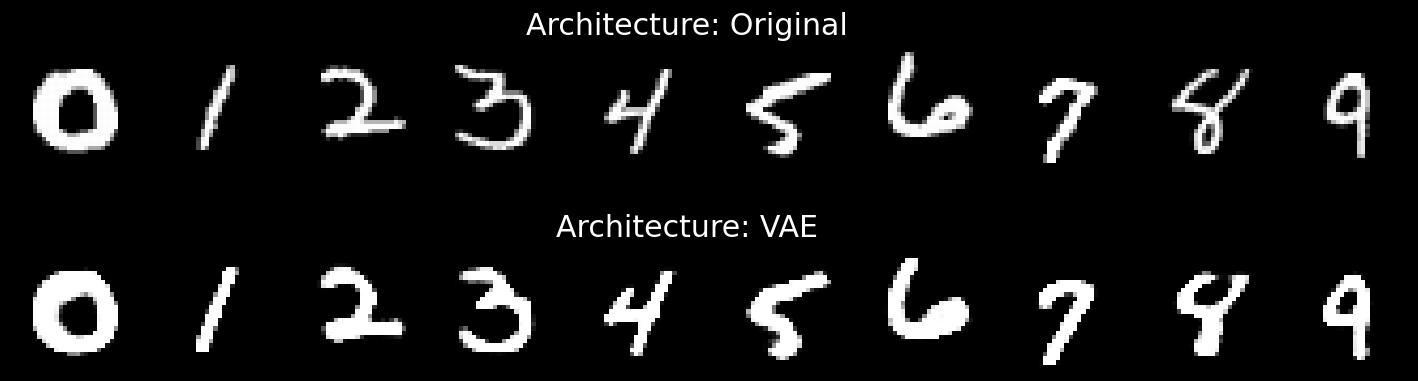

In [43]:
compare_generated_to_original_mnist({'VAE': vae}, mnist_test);

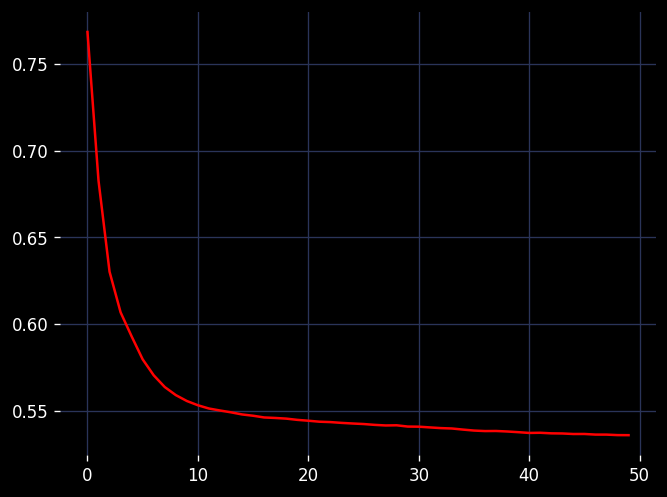

In [44]:
plt.plot(r_loss)

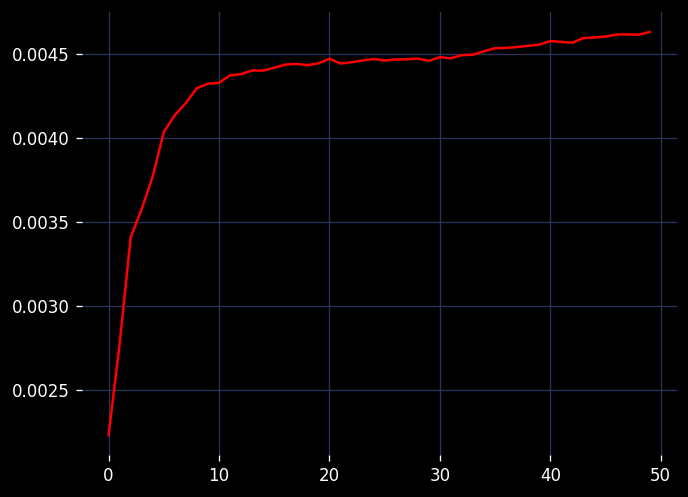

In [45]:
plt.plot(kld_loss)